In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.spatial import Delaunay
from scipy.spatial import voronoi_plot_2d, Voronoi
import statistics
sns.set_style('darkgrid')

In [2]:
class point:
    
    def __init__(self, x, y):
        '''Constructor'''
        self.x = x
        self.y = y

In [3]:
class polygon:
    
    def __init__(self, vertices, vor = False):
        '''Constructor'''
        self.vertices = vertices
        self.n = len(vertices)
        self.vor = vor
        
        self.area = 0
        
        self.list_triangles = []
        
        if len(vertices) < 3:
            print ("Error: To create a polygon you need at least 3 points")
        
    
    def show(self):
        '''Draw the polygon'''
        if not self.vor == False:
            voronoi_plot_2d(self.vor)
            
        eje_x = []
        eje_y = []

        for p in self.vertices:
            eje_x = eje_x + [p.x]
            eje_y = eje_y + [p.y]
        plt.fill(eje_x, eje_y)
        plt.show()
    
    
    def same_line(self, line ,p1, p2):
        '''
        Returns if the points are on the same 
        line and on which line.

        Args:
            line (array): Vertices corresponding to a line.
            p (point): Polygon point.
            q (point): Polygon point.

        Returns:
            boolean: If the two points correspond to the same line.
            boolean: If the two points correspond to the line.
        '''
        p1_status = 0
        p2_status = 0
        
        #Check if they correspond to the same line
        for p in line:
            if p == p1:
                p1_status = 1
            if p == p2:
                p2_status = 1
        
        #If they are on the same line, it is returned in which
        if p1_status == p2_status:
            if p1_status == 1:
                return True, True
            else:
                return True, False
        
        return False, True
    
    
    def draw_triangulation(self):
        '''Draw triangulation'''
        for triang in self.list_triangles:
            eje_x = []
            eje_y = []
            for p in triang.vertices:
                eje_x = eje_x + [p.x]
                eje_y = eje_y + [p.y]
            plt.fill(eje_x, eje_y)
        plt.show()
        
        
    def create_lines(self, sortVertices):
        '''
        Based on the first vertex in the list, 
        two lines are created, left and right.

        Args:
            sortVertices (array): Sort vertices of the polygon.

        Returns:
            [array]: Vertices corresponding to the line on the left.
            [array]: Vertices corresponding to the line on the right.
        '''
        verticesRight = []
        verticesLeft = []
        
        #Sort edges on two lines, left and right
        for p in sortVertices:
            if p == sortVertices[0]:
                verticesLeft.append(p)
            else:
                if sortVertices[0].x < p.x:
                    verticesRight.append(p)
                else:
                    verticesLeft.append(p)
                    
        #Sort vertices descending
        verticesRight = sorted(verticesRight, key=lambda x: x.y, reverse=True) 
        verticesLeft = sorted(verticesLeft, key=lambda x: x.y, reverse=True)
        
        return verticesLeft, verticesRight
    
    
    def area_triang(self, p, q, r):
        '''
        Calculation of the area of a triangle.

        Args:
            p (array): Coords of a triangle point.
            q (array): Coords of a triangle point.
            r (array): Coords of a triangle point.
        Returns:
            float: Triangle area.
        '''
        pq = q-p
        pr = r-p
        
        return np.linalg.norm(np.cross(pq, pr))/2
    
    
    def area_total(self):
        '''Show polygon area.'''
        if not self.list_triangles:
            print("To show the total area, it is first necessary to make the trigulation of the polygon.")
        else:
            #Sum of the area for each triangle that makes up the polygon
            for triang in self.list_triangles:
                self.area += self.area_triang(np.array([triang.vertices[0].x, triang.vertices[0].y]), np.array([triang.vertices[1].x, triang.vertices[1].y]), np.array([triang.vertices[2].x, triang.vertices[2].y]))
            print(f'The total area of the polygon is: {self.area}u')
            
            
    def voronoi_convex_hull(self):
        '''
        Calculate from the voronoi convex hull of the polygon.

        Returns:
            polygon: Polygon with voronio convex hull.
        '''
        vertices_pol = []
        vertices_vor = []
        for i in range(self.n):
            vertices_pol.append((self.vertices[i].x, self.vertices[i].y))
            
        return polygon(self.vertices, Voronoi(vertices_pol))
          
        
    def convex_hull(self, algorithm = 'jarvis'):
        '''
        Run convex hull algorithm type.

        Args:
            algorithm (str): Type of algorithm.
            
        Returns:
            polygon: Polygon with the calculation of the convex hull algorithm.
        '''
        if algorithm == 'jarvis':
            return self.jarvis()
        else:
            if algorithm == 'graham':
                return self.graham()
            else:
                print(f'The type of convex hull must be jarvis or graham.')
    
    
    def get_angle(self, a, b, c):
        '''
        Calculates the angle between the vector ab and the point c.

        Args:
            a (point): Coords of a point.
            b (point): Coords of a point.
            c (point): Coords of a point.
        Returns:
            float: Angle between ab and c.
        '''
        angle = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))

        if angle < 0:
            return angle + 360

        return angle
    
    
    def jarvis(self):
        '''
        Calculate from the jarvis convex hull of the polygon.

        Returns:
            polygon: Polygon with jarvis convex hull.
        '''
        Q = []
        sortVerticesAsc = self.vertices
        
        #Sort polygon vertices ascending
        sortVerticesAsc = sorted(sortVerticesAsc, key=lambda x: x.y, reverse=False)
        
        for i in range(self.n):
            #reset angle comparation
            last_angle = 361
            #Add the first vertex  to the queue
            if i == 0:
                Q.append(sortVerticesAsc[0])
            else:
                #First iteration
                if len(Q) == 1:
                    for j in range(len(sortVerticesAsc)):
                        #Find the vertex with the smallest angle with respect to the glued vertex and the vector 1.0
                        if not Q[0] == sortVerticesAsc[j]:
                            current_angle = self.get_angle(Q[0], point(Q[0].x + 1, Q[0].y), sortVerticesAsc[j])
                            if current_angle < last_angle:
                                last_angle = current_angle
                                indice = j
                    Q.append(sortVerticesAsc[indice])
                else:
                    for j in range(len(sortVerticesAsc)):
                        #Find the vertex with the smallest angle with respect to two first vertex to the queue
                        if not Q[len(Q)-2] == sortVerticesAsc[j] and not Q[len(Q)-1] == sortVerticesAsc[j]:
                            current_angle = self.get_angle(Q[len(Q)-2], Q[len(Q)-1], sortVerticesAsc[j])
                            if current_angle < last_angle:
                                last_angle = current_angle
                                indice = j
                    if sortVerticesAsc[j] == Q[0]:
                        break
                    else:
                        Q.append(sortVerticesAsc[indice])
                        
        return polygon(Q)
        
        
    def graham(self):
        '''
        Calculate from the graham convex hull of the polygon.

        Returns:
            polygon: Polygon with graham convex hull.
        '''
        Q = []
        sortVerticesAsc = self.vertices
        sortVerticesDes = self.vertices
        
        #Sort polygon vertices ascending
        sortVerticesAsc = sorted(sortVerticesAsc, key=lambda x: x.x, reverse=False)
        #Sort polygon vertices descending
        sortVerticesDes = sorted(sortVerticesDes, key=lambda x: x.x, reverse=True)
        
        for i in range(self.n):
            #Add the first two vertices to the queue
            if i < 2:
                Q.append(sortVerticesAsc[i])
            else:
                #If the new vertex is to the right, add new vertex
                if self.get_angle(Q[len(Q)-2], Q[len(Q)-1], sortVerticesAsc[i]) < 180:
                    Q.append(sortVerticesAsc[i])
                else:
                    for j in range(len(Q)):
                        #Remove the last vertex until the new vertex is to the right, add new vertex
                        if self.get_angle(Q[len(Q)-(j+2)], Q[len(Q)-(j+1)], sortVerticesAsc[i]) >= 180:
                            Q.remove(Q[len(Q)-(j+1)])
                        else:
                            Q.append(sortVerticesAsc[i])
                            break
                            
        #Last iteration
        for j in range(len(Q)):
            if self.get_angle(Q[len(Q)-(j+3)], Q[len(Q)-(j+2)], Q[len(Q)-(j+1)]) >= 180:
                Q.remove(Q[len(Q)-(j+2)])
                
        #Run vertices in the opposite direction
        for i in range(self.n):
            #Check if the vertex is already in Q
            inQ = False
            for j in range(len(Q)):
                if Q[j] == sortVerticesDes[i]:
                    inQ = True
                    break
            if not inQ:
                #If the new vertex is to the right, add new vertex
                if self.get_angle(Q[len(Q)-2], Q[len(Q)-1], sortVerticesDes[i]) <= 180:
                    Q.append(sortVerticesDes[i])
                else:
                    for j in range(len(Q)):
                        #Remove the last vertex until the new vertex is to the right, add new vertex
                        if self.get_angle(Q[len(Q)-(j+2)], Q[len(Q)-(j+1)], sortVerticesDes[i]) > 180:
                            Q.remove(Q[len(Q)-(j+1)])
                        else:
                            Q.append(sortVerticesDes[i])
                            break
                            
        #Last iteration compared to the first element of Q
        for j in range(len(Q)):
            if self.get_angle(Q[len(Q)-(j+2)], Q[len(Q)-(j+1)], Q[0]) > 180:
                Q.remove(Q[len(Q)-(j+1)])
                
        return polygon(Q)
    
    
    def monotone_triang(self, plot=False):
        '''
        Y-monotone triangulation of the polygon.

        Args:
            plot (boolean): Indicates whether the triangulation should be drawn.
        '''
        lineRight = []
        lineLeft = []
        Q = []
        sortVertices = self.vertices
        
        #Sort polygon vertices descending
        sortVertices = sorted(sortVertices, key=lambda x: x.y, reverse=True)
        
        #Create the left and right line
        lineLeft, lineRight = self.create_lines(sortVertices)
        
        #Y-monotone algorithm
        for i in range(self.n):
            #Add the first two vertices to the queue
            if i < 2:
                Q.append(sortVertices[i])
            else:
                #Calculate if the next vertex belongs to the same line as the previous one
                same_line, right = self.same_line(lineRight, Q[len(Q)-1] ,sortVertices[i])
                #Add vertex to queue, if they belong to the same line and the next vertex is not visible from the previous one
                if same_line and ((right and Q[len(Q)-1].x < sortVertices[i].x) or (not right and Q[len(Q)-1].x > sortVertices[i].x)):
                    Q.append(sortVertices[i])
                else:
                    #If they do not belong to the same, carry out triangulation
                    if not same_line:
                        for j in range(len(Q)-1):
                            self.list_triangles.append(polygon([Q[j], Q[j+1], sortVertices[i]]))
                        p_aux = Q[len(Q)-1]
                        Q = []
                        Q.append(p_aux)
                        Q.append(sortVertices[i])
                    #Ear Clipping 
                    else:
                        self.list_triangles.append(polygon([Q[len(Q)-2], Q[len(Q)-1], sortVertices[i]]))
                        Q.remove(Q[len(Q)-1])
                        Q.append(sortVertices[i])
        
        #Draw triangulation if indicated
        if plot:
            self.draw_triangulation()

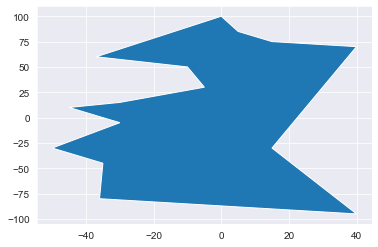

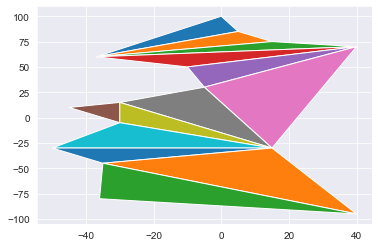

The total area of the polygon is: 9800.0u


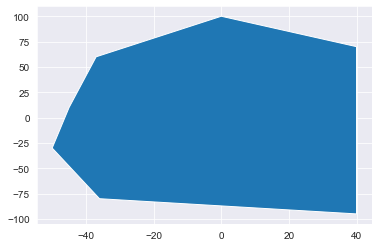

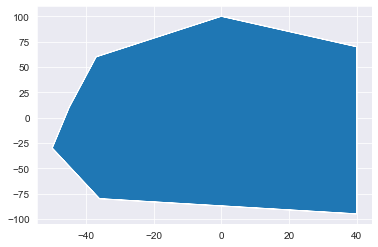

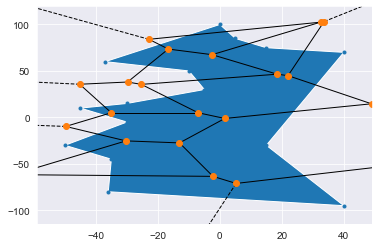

In [4]:
p1 = point(0, 100)
p2 = point(5, 85)
p3 = point(15, 75)
p4 = point(40, 70)
p5 = point(15, -30)
p6 = point(40, -95)
p7 = point(-36, -80)
p8 = point(-10, -55)
p9 = point(-35, -45)
p10 = point(-50, -30)
p11 = point(-30, -5)
p12 = point(-45, 10)
p13 = point(-30, 15)
p14 = point(-5, 30)
p15 = point(-10, 50)
p16 = point(-37, 60) 

vertices = [p1,p2,p3,p4,p5,p6,p7,p9,p10,p11,p12,p13,p14,p15,p16]

#Create polygon
pol = polygon(vertices)

#Show Polygon
pol.show()

#Y-monotone polygon triangulation
pol.monotone_triang(True)

#Calculate area
pol.area_total()

#Convex hull with graham and with jarvis
graham = pol.convex_hull('graham')
jarvis = pol.convex_hull('jarvis')
graham.show()
jarvis.show()

#Voronoi Convex Hull
voronoi_convex_hull = pol.voronoi_convex_hull()
voronoi_convex_hull.show()